

# Dataset source: https://www.kaggle.com/competitions/home-credit-default-risk



In [ ]:
!pip install pyspark

In [ ]:
!pip install scikit-learn

In [ ]:
import pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, lit
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import rand
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import coalesce
from pyspark.sql.functions import sum as _sum, log
import pandas as pd
import numpy as np
from pyspark.sql import DataFrame
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
df_app_train = spark.read.csv('/content/application_train.csv', header=True, inferSchema=True)
df_descript = spark.read.csv('/content/HomeCredit_columns_description.csv', header=True, inferSchema=True)
df_bureau = spark.read.csv('/content/bureau.csv', header=True, inferSchema=True)
df_previous_application = spark.read.csv('/content/previous_application.csv', header=True, inferSchema=True)

# **EDA**

In [ ]:
df_app_train.printSchema()
df_app_train.count()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

307511

In [ ]:
df_bureau.printSchema()
df_bureau.count()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- SK_ID_BUREAU: integer (nullable = true)
 |-- CREDIT_ACTIVE: string (nullable = true)
 |-- CREDIT_CURRENCY: string (nullable = true)
 |-- DAYS_CREDIT: integer (nullable = true)
 |-- CREDIT_DAY_OVERDUE: integer (nullable = true)
 |-- DAYS_CREDIT_ENDDATE: double (nullable = true)
 |-- DAYS_ENDDATE_FACT: double (nullable = true)
 |-- AMT_CREDIT_MAX_OVERDUE: double (nullable = true)
 |-- CNT_CREDIT_PROLONG: integer (nullable = true)
 |-- AMT_CREDIT_SUM: double (nullable = true)
 |-- AMT_CREDIT_SUM_DEBT: double (nullable = true)
 |-- AMT_CREDIT_SUM_LIMIT: double (nullable = true)
 |-- AMT_CREDIT_SUM_OVERDUE: double (nullable = true)
 |-- CREDIT_TYPE: string (nullable = true)
 |-- DAYS_CREDIT_UPDATE: integer (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)



1716428

In [ ]:
df_previous_application.printSchema()
df_previous_application.count()

root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_APPLICATION: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_DOWN_PAYMENT: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- WEEKDAY_APPR_PROCESS_START: string (nullable = true)
 |-- HOUR_APPR_PROCESS_START: integer (nullable = true)
 |-- FLAG_LAST_APPL_PER_CONTRACT: string (nullable = true)
 |-- NFLAG_LAST_APPL_IN_DAY: integer (nullable = true)
 |-- RATE_DOWN_PAYMENT: double (nullable = true)
 |-- RATE_INTEREST_PRIMARY: double (nullable = true)
 |-- RATE_INTEREST_PRIVILEGED: double (nullable = true)
 |-- NAME_CASH_LOAN_PURPOSE: string (nullable = true)
 |-- NAME_CONTRACT_STATUS: string (nullable = true)
 |-- DAYS_DECISION: integer (nullable = true)
 |-- NAME_PAYMENT_TYPE: string (nullable = true)
 |-- CODE_REJECT_REASON: string (nullable = t

1670214

In [ ]:
df_app_train.show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+------------

In [ ]:
df_app_train.describe().show()

+-------+------------------+-------------------+------------------+-----------+------------+---------------+------------------+------------------+------------------+------------------+-----------------+---------------+----------------+--------------------+------------------+-----------------+--------------------------+-------------------+------------------+------------------+-------------------+------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------------+------------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+-------------------+-------------------+---------------------------+-------------------+--

# **CLEAN DATA**

In [ ]:
feature_columns = [
    # Thông tin cá nhân và nhân khẩu học
    'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'CNT_CHILDREN', 'NAME_FAMILY_STATUS', 'CNT_FAM_MEMBERS',
    'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',

    # Thông tin tài chính
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',

    # Thông tin nghề nghiệp và việc làm
    'NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'OCCUPATION_TYPE', 'DAYS_EMPLOYED', 'ORGANIZATION_TYPE',

    # Lịch sử tín dụng
    'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

# Lọc các cột quan trọng
df_data_p1 = df_app_train.select(*feature_columns)

# Hiển thị 5 dòng đầu tiên
df_data_p1.show(5)

+----------+------+-----------+------------+---------------+------------+--------------------+---------------+-----------------+--------------------------+----------+----------------+----------+-----------+---------------+-------------------+------------------+-------------------+------------------+----------------+--------------------+---------------+-------------+--------------------+-----------------+---------------+------------------------+------------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+
|SK_ID_CURR|TARGET|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|  NAME_FAMILY_STATUS|CNT_FAM_MEMBERS|NAME_HOUSING_TYPE|REGION_POPULATION_RELATIVE|DAYS_BIRTH|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|       EXT_SOURCE_1|      EXT_SOURCE_2|       EXT_SOURCE_3|NAME_CONTRACT_TYPE|NAME_INCOME_TYPE|

In [ ]:
# Tính số lượng giá trị bị thiếu cho từng cột
missing_count = df_data_p1.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df_data_p1.columns
])

# Hiển thị kết quả
missing_count.show()

+----------+------+-----------+------------+---------------+------------+------------------+---------------+-----------------+--------------------------+----------+----------------+----------+-----------+---------------+------------+------------+------------+------------------+----------------+-------------------+---------------+-------------+-----------------+-----------------+---------------+------------------------+------------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+
|SK_ID_CURR|TARGET|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|NAME_FAMILY_STATUS|CNT_FAM_MEMBERS|NAME_HOUSING_TYPE|REGION_POPULATION_RELATIVE|DAYS_BIRTH|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|EXT_SOURCE_1|EXT_SOURCE_2|EXT_SOURCE_3|NAME_CONTRACT_TYPE|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|OCCUPATION_TYPE|DAYS_EMPLOYE

In [ ]:
# Drop cột bị thiếu gần 60%
df_data_p1 = df_data_p1.drop('EXT_SOURCE_1')

In [ ]:
# Điền giá trị 'Laborers' cho các giá trị NULL trong cột 'OCCUPATION_TYPE'
df_data_p1 = df_data_p1.withColumn(
    'OCCUPATION_TYPE',
    when(col('OCCUPATION_TYPE').isNull(), 'Laborers').otherwise(col('OCCUPATION_TYPE'))
)

# Điền giá trị 1 cho các giá trị NULL trong cột 'CNT_FAM_MEMBERS'
df_data_p1 = df_data_p1.withColumn(
    'CNT_FAM_MEMBERS',
    when(col('CNT_FAM_MEMBERS').isNull(), 1).otherwise(col('CNT_FAM_MEMBERS'))
)


In [ ]:
columns_to_fill = [
    'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_ANNUITY'
]
# Sử dụng fillna để điền giá trị -1 cho các cột bị NULL
df_data_p1 = df_data_p1.fillna(-1, subset=columns_to_fill)

In [ ]:
median_amt_goods_price = df_data_p1.approxQuantile("AMT_GOODS_PRICE", [0.5], 0)[0]

# Sử dụng fillna để điền giá trị -1 cho các cột bị NULL
df_data_p1 = df_data_p1.fillna(-1, subset=columns_to_fill)
median_amt_goods_price = df_data_p1.approxQuantile("AMT_GOODS_PRICE", [0.5], 0)[0]

# Điền giá trị thiếu trong cột 'AMT_GOODS_PRICE' bằng trung vị
df_data_p1 = df_data_p1.withColumn(
    'AMT_GOODS_PRICE',
    when(col('AMT_GOODS_PRICE').isNull(), lit(median_amt_goods_price)).otherwise(col('AMT_GOODS_PRICE'))
)

# Tính trung vị (median) của cột 'EXT_SOURCE_2'
median_ext_source_2 = df_data_p1.approxQuantile("EXT_SOURCE_2", [0.5], 0)[0]

# Điền giá trị thiếu trong cột 'EXT_SOURCE_2' bằng trung vị
df_data_p1 = df_data_p1.withColumn(
    'EXT_SOURCE_2',
    when(col('EXT_SOURCE_2').isNull(), lit(median_ext_source_2)).otherwise(col('EXT_SOURCE_2'))
)

In [ ]:
# Nhận thấy những người có cột EXT_SOURCE_3 có giá trị bị trống đều có điểm chung là NAME_INCOME_TYPE là Working, nên em sẽ tính trung vị của những người đó mà ext_source_3 không bị trống và điền vào
filtered_data = df_data_p1.filter((col('NAME_INCOME_TYPE') == 'Working') & (col('EXT_SOURCE_3').isNotNull()))

# Tính trung vị của EXT_SOURCE_3 cho những người Working và không bị NULL
median_ext_source_3_working = filtered_data.approxQuantile("EXT_SOURCE_3", [0.5], 0)[0]

# Điền giá trị trung vị cho EXT_SOURCE_3 bị NULL với điều kiện NAME_INCOME_TYPE là 'Working'
df_data_p1 = df_data_p1.withColumn(
    'EXT_SOURCE_3',
    when((col('NAME_INCOME_TYPE') == 'Working') & (col('EXT_SOURCE_3').isNull()), lit(median_ext_source_3_working))
    .otherwise(col('EXT_SOURCE_3'))
)

In [ ]:
# Cột DAYS_EMPLOYED có giá trị lạ là vì những người ở cột đó đều đã về hưu, nên không có số liệu về số ngày đã làm công việc hiên tại
# Ta sẽ để tất cả các cột có giá trị lạ là 0, tạo thêm 1 cột IS_RETIRED để nhận biết những người đó
# Thay thế các giá trị lạ trong cột 'DAYS_EMPLOYED' với -1 nếu NAME_INCOME_TYPE là 'Pensioner'
df_data_p1 = df_data_p1.withColumn(
    'DAYS_EMPLOYED',
    when(col('NAME_INCOME_TYPE') == 'Pensioner', -1).otherwise(col('DAYS_EMPLOYED'))
)

# Tạo cột 'IS_RETIRED' để nhận biết những người có NAME_INCOME_TYPE là 'Pensioner'
df_data_p1 = df_data_p1.withColumn(
    'IS_RETIRED',
    when(col('NAME_INCOME_TYPE') == 'Pensioner', 1).otherwise(0)
)

In [ ]:
df_bureau.printSchema()


root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- SK_ID_BUREAU: integer (nullable = true)
 |-- CREDIT_ACTIVE: string (nullable = true)
 |-- CREDIT_CURRENCY: string (nullable = true)
 |-- DAYS_CREDIT: integer (nullable = true)
 |-- CREDIT_DAY_OVERDUE: integer (nullable = true)
 |-- DAYS_CREDIT_ENDDATE: double (nullable = true)
 |-- DAYS_ENDDATE_FACT: double (nullable = true)
 |-- AMT_CREDIT_MAX_OVERDUE: double (nullable = true)
 |-- CNT_CREDIT_PROLONG: integer (nullable = true)
 |-- AMT_CREDIT_SUM: double (nullable = true)
 |-- AMT_CREDIT_SUM_DEBT: double (nullable = true)
 |-- AMT_CREDIT_SUM_LIMIT: double (nullable = true)
 |-- AMT_CREDIT_SUM_OVERDUE: double (nullable = true)
 |-- CREDIT_TYPE: string (nullable = true)
 |-- DAYS_CREDIT_UPDATE: integer (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)



In [ ]:
# Tính số lượng giá trị bị thiếu cho từng cột
missing_count = df_bureau.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df_bureau.columns
])

# Hiển thị kết quả
missing_count.show()

+----------+------------+-------------+---------------+-----------+------------------+-------------------+-----------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+-----------+------------------+-----------+
|SK_ID_CURR|SK_ID_BUREAU|CREDIT_ACTIVE|CREDIT_CURRENCY|DAYS_CREDIT|CREDIT_DAY_OVERDUE|DAYS_CREDIT_ENDDATE|DAYS_ENDDATE_FACT|AMT_CREDIT_MAX_OVERDUE|CNT_CREDIT_PROLONG|AMT_CREDIT_SUM|AMT_CREDIT_SUM_DEBT|AMT_CREDIT_SUM_LIMIT|AMT_CREDIT_SUM_OVERDUE|CREDIT_TYPE|DAYS_CREDIT_UPDATE|AMT_ANNUITY|
+----------+------------+-------------+---------------+-----------+------------------+-------------------+-----------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+-----------+------------------+-----------+
|         0|           0|            0|              0|          0|                 0|             105553|           633653|         

In [ ]:
bureau_features = df_bureau.groupBy("SK_ID_CURR").agg(
    count("SK_ID_CURR").alias("num_loans"),  # Số lần vay
    _sum("CREDIT_DAY_OVERDUE").alias("total_days_overdue"),  # Tổng số ngày trả nợ trễ
    _sum("AMT_CREDIT_MAX_OVERDUE").alias("total_amt_credit_max_overdue"),  # Tổng số AMT_CREDIT_MAX_OVERDUE
    _sum("AMT_CREDIT_SUM").alias("total_amt_credit_sum"),  # Tổng số AMT_CREDIT_SUM
    _sum("AMT_CREDIT_SUM_DEBT").alias("total_amt_credit_sum_debt")  # Tổng số AMT_CREDIT_SUM_DEBT
)
bureau_features.show()

+----------+---------+------------------+----------------------------+--------------------+-------------------------+
|SK_ID_CURR|num_loans|total_days_overdue|total_amt_credit_max_overdue|total_amt_credit_sum|total_amt_credit_sum_debt|
+----------+---------+------------------+----------------------------+--------------------+-------------------------+
|    341504|        2|                 0|                         0.0|            439146.0|                390099.24|
|    197603|        7|                 0|                         0.0|           3585150.0|                      0.0|
|    330299|       15|                 0|                    49469.04|           1718253.0|                 120973.5|
|    355377|        9|                 0|                         0.0|          1657663.56|                 301477.5|
|    454739|        7|                 0|          13554.945000000002|   6310391.715000001|                 178992.0|
|    295286|        9|                 0|               

In [ ]:
# Tỷ lệ sử dụng tín dụng (Credit Utilization Ratio)
df_bureau = df_bureau.withColumn(
    "credit_utilization_ratio",
    when(col("AMT_CREDIT_SUM_LIMIT") > 0, col("AMT_CREDIT_SUM_DEBT") / col("AMT_CREDIT_SUM_LIMIT")).otherwise(0)
)

# Tính số lượng khoản vay đang hoạt động
active_loans_count = df_bureau.filter(col("CREDIT_ACTIVE") == 'Active').groupBy("SK_ID_CURR").agg(
    count("SK_ID_CURR").alias("num_active_loans")
)

# Tính số lượng khoản vay đã hoàn tất
closed_loans_count = df_bureau.filter(col("CREDIT_ACTIVE") == 'Closed').groupBy("SK_ID_CURR").agg(
    count("SK_ID_CURR").alias("num_closed_loans")
)

# Trung bình thời gian vay (Ngày kết thúc trừ ngày bắt đầu vay)
bureau_avg_loan_duration = df_bureau.groupBy("SK_ID_CURR").agg(
    avg(col("DAYS_CREDIT_ENDDATE") - col("DAYS_CREDIT")).alias("avg_loan_duration")
)

# Tổng dư nợ hiện tại
current_debt = df_bureau.filter(col("CREDIT_ACTIVE") == 'Active').groupBy("SK_ID_CURR").agg(
    _sum("AMT_CREDIT_SUM_DEBT").alias("total_active_debt")
)

# Tổng hợp tất cả thông tin đặc trưng từ bảng bureau
bureau_features = df_bureau.groupBy("SK_ID_CURR").agg(
    count("SK_ID_CURR").alias("num_loans"),  # Tổng số khoản vay
    _sum("CREDIT_DAY_OVERDUE").alias("total_days_overdue"),  # Tổng số ngày trễ hạn
    _sum("AMT_CREDIT_MAX_OVERDUE").alias("total_amt_credit_max_overdue"),  # Tổng nợ quá hạn
    _sum("AMT_CREDIT_SUM").alias("total_amt_credit_sum"),  # Tổng số tiền vay
    _sum("AMT_CREDIT_SUM_DEBT").alias("total_amt_credit_sum_debt")  # Tổng số nợ chưa thanh toán
)

# Kết hợp tất cả các đặc trưng vào một dataframe
final_bureau_features = (
    bureau_features
    .join(active_loans_count, on="SK_ID_CURR", how="left")
    .join(closed_loans_count, on="SK_ID_CURR", how="left")
    .join(bureau_avg_loan_duration, on="SK_ID_CURR", how="left")
    .join(current_debt, on="SK_ID_CURR", how="left")
)

# Hiển thị kết quả
final_bureau_features.show(5)

+----------+---------+------------------+----------------------------+--------------------+-------------------------+----------------+----------------+------------------+-----------------+
|SK_ID_CURR|num_loans|total_days_overdue|total_amt_credit_max_overdue|total_amt_credit_sum|total_amt_credit_sum_debt|num_active_loans|num_closed_loans| avg_loan_duration|total_active_debt|
+----------+---------+------------------+----------------------------+--------------------+-------------------------+----------------+----------------+------------------+-----------------+
|    197603|        7|                 0|                         0.0|           3585150.0|                      0.0|            NULL|               7| 5350.714285714285|             NULL|
|    295286|        9|                 0|                     6191.37|           2886322.5|                 871204.5|               3|               6| 1123.888888888889|         871204.5|
|    330299|       15|                 0|              

In [ ]:
df_data_p2 = final_bureau_features
total_rows = df_data_p2.count()
# Tính tỷ lệ phần trăm giá trị thiếu (null) cho mỗi cột
missing_percentage = df_data_p2.select(
    [
        (_sum(when(col(c).isNull(), 1).otherwise(0)) / total_rows * 100).alias(c + "_missing_percentage")
        for c in df_data_p2.columns
    ]
)
#Hiển thị kết quả
missing_percentage.show(truncate=False)



+-----------------------------+----------------------------+-------------------------------------+-----------------------------------------------+---------------------------------------+--------------------------------------------+-----------------------------------+-----------------------------------+------------------------------------+------------------------------------+
|SK_ID_CURR_missing_percentage|num_loans_missing_percentage|total_days_overdue_missing_percentage|total_amt_credit_max_overdue_missing_percentage|total_amt_credit_sum_missing_percentage|total_amt_credit_sum_debt_missing_percentage|num_active_loans_missing_percentage|num_closed_loans_missing_percentage|avg_loan_duration_missing_percentage|total_active_debt_missing_percentage|
+-----------------------------+----------------------------+-------------------------------------+-----------------------------------------------+---------------------------------------+--------------------------------------------+-------------

In [ ]:
# Thay thế các giá trị trống thành -1
df_data_p2 = df_data_p2.fillna(-1)

In [ ]:
# Feature engineering cho file previous_application.csv
previous_application_features = df_previous_application.groupBy("SK_ID_CURR").agg(
    count("SK_ID_PREV").alias("num_previous_loans"),  # Tổng số khoản vay trước đây
    _sum("AMT_APPLICATION").alias("total_amt_application"),  # Tổng số tiền khách hàng yêu cầu vay
    _sum("AMT_CREDIT").alias("total_amt_credit"),  # Tổng số tiền được phê duyệt
    _sum("AMT_ANNUITY").alias("total_amt_annuity"),  # Tổng số tiền trả góp hàng năm
    _sum("AMT_GOODS_PRICE").alias("total_amt_goods_price"),  # Tổng giá trị hàng hóa tài trợ
    _sum("AMT_DOWN_PAYMENT").alias("total_amt_down_payment"),  # Tổng số tiền trả trước
    mean("RATE_DOWN_PAYMENT").alias("avg_rate_down_payment"),  # Trung bình tỷ lệ trả trước
    mean("DAYS_DECISION").alias("avg_days_decision")  # Trung bình số ngày từ khi ra quyết định
)

In [ ]:
# Tính số lượng khoản vay được phê duyệt và bị từ chối
approved_loans = df_previous_application.filter(col("NAME_CONTRACT_STATUS") == "Approved").groupBy("SK_ID_CURR").agg(
    count("SK_ID_PREV").alias("num_approved_loans")
)
# Khoản vay bị từ chối
refused_loans = df_previous_application.filter(col("NAME_CONTRACT_STATUS") == "Refused").groupBy("SK_ID_CURR").agg(
    count("SK_ID_PREV").alias("num_refused_loans")
)
# Kết hợp tất cả
final_previous_features = (
    previous_application_features
    .join(approved_loans, "SK_ID_CURR", "left")
    .join(refused_loans, "SK_ID_CURR", "left")
    .fillna(-1)
)

# Hiển thị kết quả
df_data_p3 = final_previous_features
df_data_p3.show()

+----------+------------------+---------------------+----------------+-----------------+---------------------+----------------------+---------------------+-------------------+------------------+-----------------+
|SK_ID_CURR|num_previous_loans|total_amt_application|total_amt_credit|total_amt_annuity|total_amt_goods_price|total_amt_down_payment|avg_rate_down_payment|  avg_days_decision|num_approved_loans|num_refused_loans|
+----------+------------------+---------------------+----------------+-----------------+---------------------+----------------------+---------------------+-------------------+------------------+-----------------+
|    139128|                10|            1261462.5|       1307344.5|        102441.96|            1261462.5|               14413.5|  0.06649204614485478|            -1355.1|                 6|                3|
|    175295|                 9|           1488891.69|       1622857.5|        74233.575|           1488891.69|              11838.69|  0.08214264442

In [ ]:
# Kết hợp 3 dataframe theo SK_ID_CURR
final_combined_features = (
    df_data_p1
    .join(df_data_p2, on="SK_ID_CURR", how="left")
    .join(df_data_p3, on="SK_ID_CURR", how="left")
)

In [ ]:
joined_df = final_combined_features.orderBy("SK_ID_CURR")

# Hiển thị kết quả sau khi kết hợp
joined_df.show()
joined_df.count()

+----------+------+-----------+------------+---------------+------------+--------------------+---------------+-----------------+--------------------------+----------+----------------+----------+-----------+---------------+-------------------+-------------------+------------------+--------------------+--------------------+---------------+-------------+--------------------+-----------------+---------------+------------------------+------------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+----------+---------+------------------+----------------------------+--------------------+-------------------------+----------------+----------------+-----------------+-----------------+------------------+---------------------+----------------+------------------+---------------------+----------------------+---------------------+---

307511

In [ ]:
# Điền -1 vào các ô bị thiếu
cleaned_combined_df = joined_df.fillna(-1)
cleaned_combined_df.count()

307511

In [ ]:
# Tạo biến AGE
cleaned_combined_df = cleaned_combined_df.withColumn("AGE", ceil(col("DAYS_BIRTH") / -365))
# Tạo biến tỷ lệ tín dụng trên thu nhập CREDIT_INCOME_RATIO
cleaned_combined_df = cleaned_combined_df.withColumn(
    "CREDIT_INCOME_RATIO",
         col("AMT_CREDIT") / col("AMT_INCOME_TOTAL"))
# Tạo biến  tỷ lệ annuity trên thu nhập ANNUITY_INCOME_RATIO
cleaned_combined_df = cleaned_combined_df.withColumn(
    "ANNUITY_INCOME_RATIO",
         col("AMT_ANNUITY") / col("AMT_INCOME_TOTAL"))
# Tạo biến CREDIT_GOODS_RATIO
cleaned_combined_df = cleaned_combined_df.withColumn(
    "CREDIT_GOODS_RATIO",
         col("AMT_CREDIT") / col("AMT_GOODS_PRICE"))
cleaned_combined_df.select(
    "SK_ID_CURR",
    "AGE",
    "CREDIT_INCOME_RATIO",
    "ANNUITY_INCOME_RATIO",
    "CREDIT_GOODS_RATIO",
).show(10)

+----------+---+-------------------+--------------------+------------------+
|SK_ID_CURR|AGE|CREDIT_INCOME_RATIO|ANNUITY_INCOME_RATIO|CREDIT_GOODS_RATIO|
+----------+---+-------------------+--------------------+------------------+
|    100002| 26|  2.007888888888889| 0.12197777777777778|1.1583974358974358|
|    100003| 46|            4.79075| 0.13221666666666668| 1.145199203187251|
|    100004| 53|                2.0|                 0.1|               1.0|
|    100006| 53| 2.3161666666666667|              0.2199|1.0528030303030302|
|    100007| 55|  4.222222222222222| 0.17996296296296296|               1.0|
|    100008| 47|             4.9545| 0.27795454545454545|1.0791980198019802|
|    100009| 38|  9.127052631578948| 0.24152631578947367|            1.1188|
|    100010| 52|               4.25|            0.116875|               1.0|
|    100011| 56|             9.0632|             0.30068|1.1161576354679803|
|    100012| 40|                3.0|                0.15|               1.0|

In [ ]:
cleaned_combined_df.show()

+----------+------+-----------+------------+---------------+------------+--------------------+---------------+-----------------+--------------------------+----------+----------------+----------+-----------+---------------+-------------------+-------------------+------------------+--------------------+--------------------+---------------+-------------+--------------------+-----------------+---------------+------------------------+------------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+----------+---------+------------------+----------------------------+--------------------+-------------------------+----------------+----------------+-----------------+-----------------+------------------+---------------------+----------------+------------------+---------------------+----------------------+---------------------+---

In [ ]:
combined_df = cleaned_combined_df

In [ ]:
def calculate_woe_iv(df, feature, target):
    """
    Tính WOE và IV cho một biến cụ thể.
    """
    # Tạo bảng tổng hợp Good và Bad cho từng nhóm trong feature
    grouped_df = df.groupBy(feature).agg(
        _sum(when(col(target) == 0, 1).otherwise(0)).alias("good"),  # TARGET = 0
        _sum(when(col(target) == 1, 1).otherwise(0)).alias("bad")    # TARGET = 1
    )

    # Tính tỷ lệ Good và Bad
    total_good = grouped_df.selectExpr("sum(good)").collect()[0][0]
    total_bad = grouped_df.selectExpr("sum(bad)").collect()[0][0]

    # Tính WOE và IV
    grouped_df = grouped_df.withColumn("good_dist", col("good") / total_good) \
                           .withColumn("bad_dist", col("bad") / total_bad) \
                           .withColumn("woe", log(col("good_dist") / col("bad_dist"))) \
                           .withColumn("iv", (col("good_dist") - col("bad_dist")) * col("woe"))

    # Tổng IV của biến
    iv_value = grouped_df.selectExpr("sum(iv)").collect()[0][0]

    return iv_value, grouped_df

# Lọc các biến có tương quan nằm trong khoảng yêu cầu
valid_features = []

# Duyệt qua các cột và tính IV, lọc theo điều kiện
for feature in combined_df.columns:
    if feature != "TARGET" and feature != "SK_ID_CURR":
        try:
            iv, _ = calculate_woe_iv(combined_df, feature, "TARGET")
            if iv is not None and 0.05 <= iv <= 0.7:  # Lọc theo điều kiện tương quan
                valid_features.append((feature, iv))
        except Exception as e:
            print(f"Lỗi khi tính IV cho biến '{feature}': {e}")

# Chuyển kết quả thành DataFrame
valid_features_df = pd.DataFrame(valid_features, columns=["Feature", "IV"]).sort_values(by="IV", ascending=False)

# Hiển thị các biến hợp lệ
print("Các biến có hệ số IV phù hợp:")
print(valid_features_df)


Các biến có hệ số IV phù hợp:
                         Feature        IV
17         total_amt_application  0.640954
19         total_amt_goods_price  0.640628
22             avg_days_decision  0.524037
3                    AMT_ANNUITY  0.496698
25           CREDIT_INCOME_RATIO  0.441936
15             avg_loan_duration  0.420824
1                     DAYS_BIRTH  0.392690
5                   EXT_SOURCE_3  0.387644
14     total_amt_credit_sum_debt  0.349437
10             DAYS_REGISTRATION  0.334067
16             total_active_debt  0.325334
11               DAYS_ID_PUBLISH  0.271829
2                     AMT_CREDIT  0.271500
8                  DAYS_EMPLOYED  0.270522
13          total_amt_credit_sum  0.234204
18             total_amt_annuity  0.222387
20        total_amt_down_payment  0.219418
26            CREDIT_GOODS_RATIO  0.156827
21         avg_rate_down_payment  0.149311
4                AMT_GOODS_PRICE  0.128161
12  total_amt_credit_max_overdue  0.103094
24                      

In [ ]:
# Lấy danh sách các biến từ cột 'Feature'
good_feature = valid_features_df["Feature"].tolist()

# Hiển thị danh sách các biến
print("Danh sách các biến có IV phù hợp:")
print(good_feature)


Danh sách các biến có IV phù hợp:
['total_amt_application', 'total_amt_goods_price', 'avg_days_decision', 'AMT_ANNUITY', 'CREDIT_INCOME_RATIO', 'avg_loan_duration', 'DAYS_BIRTH', 'EXT_SOURCE_3', 'total_amt_credit_sum_debt', 'DAYS_REGISTRATION', 'total_active_debt', 'DAYS_ID_PUBLISH', 'AMT_CREDIT', 'DAYS_EMPLOYED', 'total_amt_credit_sum', 'total_amt_annuity', 'total_amt_down_payment', 'CREDIT_GOODS_RATIO', 'avg_rate_down_payment', 'AMT_GOODS_PRICE', 'total_amt_credit_max_overdue', 'AGE', 'REGION_POPULATION_RELATIVE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'num_refused_loans', 'NAME_EDUCATION_TYPE']


In [ ]:
# Lấy 20 biến có IV cao nhất từ valid_features_df
top_20_features = valid_features_df.head(20)["Feature"].tolist()

# Thêm cột 'p1_TARGET' vào danh sách
if "p1_TARGET" not in top_20_features:
    top_20_features.append("TARGET")

# Thêm cột 'SK_ID_CURR' vào danh sách
if "SK_ID_CURR" not in top_20_features:
    top_20_features.append("SK_ID_CURR")

# Tạo DataFrame mới từ combined_df với các cột đã chọn
data_to_train_model = combined_df.select(*top_20_features)

# Hiển thị 5 dòng đầu tiên của DataFrame mới
data_to_train_model.show(5)


+---------------------+---------------------+-------------------+-----------+-------------------+-----------------+----------+-------------------+-------------------------+-----------------+-----------------+---------------+----------+-------------+--------------------+-----------------+----------------------+------------------+---------------------+---------------+------+----------+
|total_amt_application|total_amt_goods_price|  avg_days_decision|AMT_ANNUITY|CREDIT_INCOME_RATIO|avg_loan_duration|DAYS_BIRTH|       EXT_SOURCE_3|total_amt_credit_sum_debt|DAYS_REGISTRATION|total_active_debt|DAYS_ID_PUBLISH|AMT_CREDIT|DAYS_EMPLOYED|total_amt_credit_sum|total_amt_annuity|total_amt_down_payment|CREDIT_GOODS_RATIO|avg_rate_down_payment|AMT_GOODS_PRICE|TARGET|SK_ID_CURR|
+---------------------+---------------------+-------------------+-----------+-------------------+-----------------+----------+-------------------+-------------------------+-----------------+-----------------+---------------+--

In [ ]:
# Tách dữ liệu thành train (70%) và test (30%) bằng randomSplit
train_model, test_model = data_to_train_model.randomSplit([0.7, 0.3], seed=42)

# Hiển thị số lượng dòng trong mỗi tập
print(f"Số dòng trong tập train: {train_model.count()}")
print(f"Số dòng trong tập test: {test_model.count()}")

Số dòng trong tập train: 215292
Số dòng trong tập test: 92223


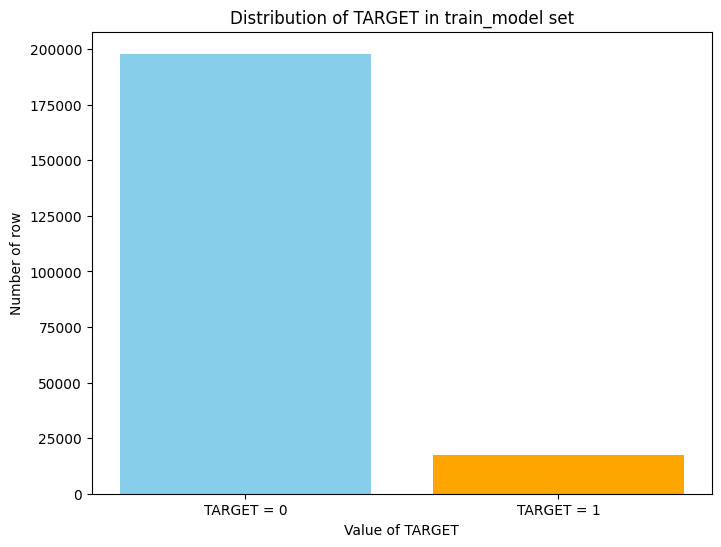

In [ ]:
# Đếm số dòng có TARGET = 0 và TARGET = 1 trong tập train_model
target_count = train_model.groupBy("TARGET").count().collect()

# Chuyển kết quả đếm sang dạng từ điển
target_dict = {row["TARGET"]: row["count"] for row in target_count}
target_0 = target_dict.get(0, 0)
target_1 = target_dict.get(1, 0)

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.bar(["TARGET = 0", "TARGET = 1"], [target_0, target_1], color=["skyblue", "orange"])
plt.title("Distribution of TARGET in train_model set")
plt.ylabel("Number of row")
plt.xlabel("Value of TARGET")
plt.show()

In [ ]:
print(f"Số dòng có TARGET = 0: {target_0}")
print(f"Số dòng có TARGET = 1: {target_1}")

Số dòng có TARGET = 0: 197950
Số dòng có TARGET = 1: 17331


In [ ]:
# Cân bằng lại 2 lớp train và test
def oversample_minority_class(df, target_column="TARGET", majority_class=0, minority_class=1):
    """
    Random Oversampling để cân bằng lớp thiểu số và lớp đa số.
    """
    # Tách lớp đa số và lớp thiểu số
    majority_df = df.filter(col(target_column) == majority_class)
    minority_df = df.filter(col(target_column) == minority_class)

    # Tính số lượng dòng trong mỗi lớp
    majority_count = majority_df.count()
    minority_count = minority_df.count()

    print(f"Number of TARGET = {majority_class}: {majority_count}")
    print(f"Number of TARGET = {minority_class}: {minority_count}")

    # Tính tỷ lệ cần oversampling
    sampling_ratio = majority_count / minority_count

    print(f"Oversampling Rate Needed: {sampling_ratio:.2f}")

    # Oversampling lớp thiểu số bằng cách lấy mẫu có lặp (withReplacement=True)
    oversampled_minority_df = minority_df.sample(withReplacement=True, fraction=sampling_ratio, seed=42)

    # Kết hợp lớp đa số và lớp thiểu số đã oversample
    balanced_df = majority_df.union(oversampled_minority_df)

    # Kiểm tra kết quả
    balanced_df.groupBy(target_column).count().show()

    return balanced_df

# Thực hiện Oversampling trên tập train_model
balanced_train_model = oversample_minority_class(train_model, target_column="TARGET")
# Kiểm tra kết quả sau khi cân bằng
balanced_train_model.groupBy("TARGET").count().show()



Number of TARGET = 0: 197873
Number of TARGET = 1: 17411
Oversampling Rate Needed: 11.36
+------+------+
|TARGET| count|
+------+------+
|     0|197664|
|     1|198676|
+------+------+

+------+------+
|TARGET| count|
+------+------+
|     0|197664|
|     1|198676|
+------+------+



In [ ]:
# Chọn các cột đặc trưng để huấn luyện
feature_columns = [col for col in balanced_train_model.columns if col not in ["TARGET", "SK_ID_CURR"]]

# Tạo VectorAssembler để kết hợp các cột đặc trưng thành cột 'features'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Tạo cột 'features' cho tập train
train_data = assembler.transform(balanced_train_model).select("features", "TARGET")

# Tạo cột 'features' cho tập test
test_data = assembler.transform(test_model).select("features", "TARGET")

# Tìm threshold tối ưu với ROC-AUC và Recall
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

best_threshold = 0.5
best_roc_auc = 0
best_recall = 0

thresholds = [x / 100.0 for x in range(1, 100)]

for threshold in thresholds:
    # Huấn luyện mô hình Logistic Regression với threshold thử nghiệm
    lr = LogisticRegression(labelCol="TARGET", featuresCol="features", threshold=threshold, maxIter=10)
    lr_model = lr.fit(train_data)

    # Dự đoán trên tập test
    predictions = lr_model.transform(test_data)

    # Đánh giá Recall
    tp = predictions.filter((predictions.TARGET == 1) & (predictions.prediction == 1)).count()
    fn = predictions.filter((predictions.TARGET == 1) & (predictions.prediction == 0)).count()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Đánh giá ROC-AUC
    evaluator = BinaryClassificationEvaluator(labelCol="TARGET", rawPredictionCol="rawPrediction")
    roc_auc = evaluator.evaluate(predictions)

    # Cập nhật nếu recall và roc-auc đạt yêu cầu
    if recall > 0.85 and roc_auc > best_roc_auc:
        best_threshold = threshold
        best_roc_auc = roc_auc
        best_recall = recall

print(f"Threshold tối ưu: {best_threshold}, Recall: {best_recall}, ROC-AUC: {best_roc_auc}")

# Huấn luyện mô hình cuối cùng với threshold tốt nhất
final_lr = LogisticRegression(labelCol="TARGET", featuresCol="features", threshold=best_threshold, maxIter=10)
final_model = final_lr.fit(train_data)
final_predictions = final_model.transform(test_data)


Threshold tối ưu: 0.28, Recall: 0.9818499596665771, ROC-AUC: 0.6569665348973552


In [ ]:
# Chọn các cột đặc trưng để huấn luyện
feature_columns = [col for col in balanced_train_model.columns if col not in ["TARGET", "SK_ID_CURR"]]

# Tạo VectorAssembler để kết hợp các cột đặc trưng thành cột 'features'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Tạo cột 'features' cho tập train
train_data = assembler.transform(balanced_train_model).select("features", "TARGET")

# Tạo cột 'features' cho tập test
test_data = assembler.transform(test_model).select("features", "TARGET")

# Huấn luyện Logistic Regression, giảm threshold để ưu tiên Recall
lr = LogisticRegression(labelCol="TARGET", featuresCol="features", threshold=0.28, maxIter=10)
lr_model = lr.fit(train_data)


In [ ]:
# Dự đoán trên tập final_model
final_predictions = lr_model.transform(test_data)
# Tính các chỉ số Precision và Recall trên tập test
tp = final_predictions.filter((col("TARGET") == 1) & (col("prediction") == 1)).count()
fp = final_predictions.filter((col("TARGET") == 0) & (col("prediction") == 1)).count()
fn = final_predictions.filter((col("TARGET") == 1) & (col("prediction") == 0)).count()
tn = final_predictions.filter((col("TARGET") == 0) & (col("prediction") == 0)).count()

precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) != 0 else 0

# Tính AUC (ROC-AUC) trên tập test
evaluator_auc = BinaryClassificationEvaluator(labelCol="TARGET", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(final_predictions)

# In kết quả đánh giá
print(f"Precision score: {precision:.4f}")
print(f"Recall score: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")
print(f"ROC-AUC score: {auc:.4f}")

Precision score: 0.0840
Recall score: 0.9820
F1 score: 0.1547
ROC-AUC score: 0.6513


In [ ]:
print(f"true positive: {tp:.4f}")
print(f"true negative {tn:.4f}")
print(f"False positive: {fp:.4f}")
print(f"false negative: {fn:.4f}")

true positive: 7356.0000
true negative 4615.0000
False positive: 80225.0000
false negative: 135.0000


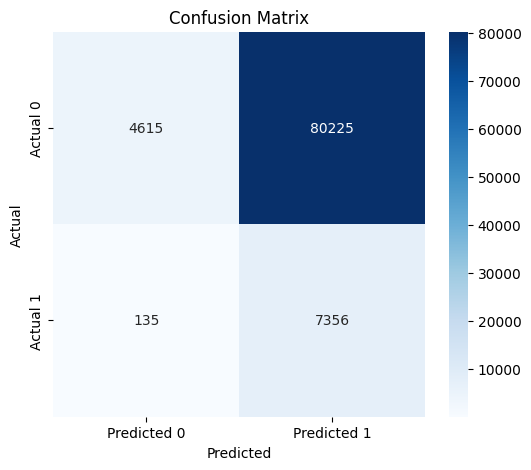

In [ ]:
# Tạo Confusion Matrix
confusion_matrix = [[tn, fp], [fn, tp]]

# Vẽ biểu đồ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
